In [7]:
# pip install gdow
# pip install google-cloud-bigquery
# pip install altair
# pip install db-dtypes
# pip install google-cloud-bigquery-storage

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 244 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 15.8 MB/s eta 0:00:01
     |████████████████████████████████| 210 kB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 158 kB 95.9 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 22.7 MB/s eta 0:00:01
     |████████████████████████████████| 221 kB 63.3 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 27.1 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 417 kB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 9.7 MB/s  eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.

In [10]:
import pandas as pd
import numpy as np
import altair as alt
from google.cloud import bigquery
# Provide credentials to the runtime (google collab only)
# from google.colab import auth 
from google.cloud.bigquery import magics

project_id = 'quantmu-ml-hackaton' #@param {type: "string"}
# Set the default project id for %bigquery magic
magics.context.project = project_id

# Use the client to run queries constructed from a more complicated function.
client = bigquery.Client(project=project_id)

Querying BigQuery...
Unique Machines: 10001


### Get the number of Unique Machines

In [5]:
query = """
SELECT COUNT(DISTINCT machine_id) AS unique_machines
FROM `google.com:google-cluster-data.clusterdata_2019_a.machine_events`
"""

# Execute the query
query_job = client.query(query)

# Fetch and display the results
print("Querying BigQuery...")
for row in query_job:
    print(f"Unique Machines: {row.unique_machines}")

Querying BigQuery...
Unique Machines: 10001


### Get a machine id

In [8]:
# Simple query to find a machine id
query = """
SELECT DISTINCT machine_id
FROM `google.com:google-cluster-data.clusterdata_2019_c.instance_usage`
LIMIT 1
"""
query_job = client.query(query)

# Fetch the result and extract the machine_id
result = query_job.result()  # This returns an iterator
machine_id = None
for row in result:
    machine_id = row.machine_id  # Access the field
    break

print(f"Fetched machine_id: {machine_id}")

Fetched machine_id: 102892361


### Table Schema

In [11]:
# Query to get the table schema
table_id = "google.com:google-cluster-data.clusterdata_2019_c.instance_usage"
table = client.get_table(table_id)

print("Schema for table:", table_id)
for field in table.schema:
    print(f"{field.name} ({field.field_type})")

Schema for table: google.com:google-cluster-data.clusterdata_2019_c.instance_usage
start_time (INTEGER)
end_time (INTEGER)
collection_id (INTEGER)
instance_index (INTEGER)
machine_id (INTEGER)
alloc_collection_id (INTEGER)
alloc_instance_index (INTEGER)
collection_type (INTEGER)
average_usage (RECORD)
maximum_usage (RECORD)
random_sample_usage (RECORD)
assigned_memory (FLOAT)
page_cache_memory (FLOAT)
cycles_per_instruction (FLOAT)
memory_accesses_per_instruction (FLOAT)
sample_rate (FLOAT)
cpu_usage_distribution (FLOAT)
tail_cpu_usage_distribution (FLOAT)


### Number of raws in the instance_usage table

In [28]:
query = """
SELECT COUNT(*) AS row_count
FROM `google.com:google-cluster-data.clusterdata_2019_c.instance_usage`
"""

# Execute the query
query_job = client.query(query)

# Fetch the result
result = query_job.result()
for row in result:
    print(f"Row count: {row.row_count}")


Row count: 8344932019


### Maximum Average CPU Usage

In [29]:
query = """
SELECT
    MAX(average_usage.cpus) AS max_average_cpu_usage
FROM
    `google.com:google-cluster-data.clusterdata_2019_c.instance_usage`
"""

# Execute the query
query_job = client.query(query)

# Fetch the result
result = query_job.result()
for row in result:
    print(f"Maximum Average CPU Usage: {row.max_average_cpu_usage}")


Forbidden: 403 Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas; reason: quotaExceeded, location: unbilled.analysis, message: Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas

Location: US
Job ID: 12e5083f-795e-4088-8a84-6dc785dae5de


# Get the CPU usage of a single machine
### Execute the query only once!

In [20]:
# Simple query to get CPU usage for a single machine
query = """
SELECT
    start_time AS time,  -- Use start_time as the time column
    average_usage.cpus AS cpu_usage
FROM
    `google.com:google-cluster-data.clusterdata_2019_c.instance_usage`
WHERE
    machine_id = 102892361
ORDER BY
    time ASC
LIMIT 10000
"""

# Execute query and fetch data into a Pandas DataFrame
query_job = client.query(query)
df_102892361 = query_job.to_dataframe()

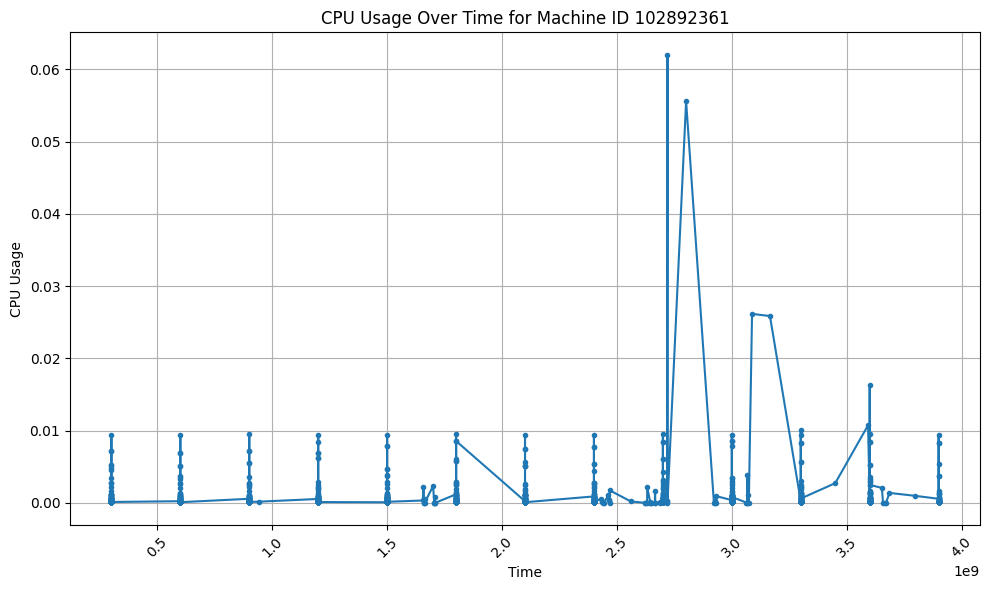

In [31]:
import matplotlib.pyplot as plt

# Convert time from microseconds (or adjust as needed based on dataset format)
#df_102892361['time'] = pd.to_datetime(df_102892361['time'], unit='us')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_102892361['time'], df_102892361['cpu_usage'], marker='o', linestyle='-', markersize=3)
plt.title("CPU Usage Over Time for Machine ID 102892361")
plt.xlabel("Time")
plt.ylabel("CPU Usage")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Cell level resource usage time series
This query takes a cell as input and plots a resource usage time-series for every hour of the trace broken down by tier.

In [4]:

#@title Select a cell and a resource to plot the cell level usage series

def query_cell_capacity(cell):
  return '''
SELECT SUM(cpu_cap) AS cpu_capacity,
  SUM(memory_cap) AS memory_capacity
FROM (
  SELECT machine_id, MAX(capacity.cpus) AS cpu_cap,
    MAX(capacity.memory) AS memory_cap
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.machine_events
  GROUP BY 1
)
  '''.format(cell=cell)

def query_per_instance_usage_priority(cell):
  return '''
SELECT u.time AS time,
  u.collection_id AS collection_id,
  u.instance_index AS instance_index,
  e.priority AS priority,
  CASE
    WHEN e.priority BETWEEN 0 AND 99 THEN '1_free'
    WHEN e.priority BETWEEN 100 AND 115 THEN '2_beb'
    WHEN e.priority BETWEEN 116 AND 119 THEN '3_mid'
    ELSE '4_prod'
  END AS tier,
  u.cpu_usage AS cpu_usage,
  u.memory_usage AS memory_usage
FROM (
  SELECT start_time AS time,
    collection_id,
    instance_index,
    machine_id,
    average_usage.cpus AS cpu_usage,
    average_usage.memory AS memory_usage
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_usage
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
    AND (end_time - start_time) >= (5 * 60 * 1e6)
) AS u JOIN (
  SELECT collection_id, instance_index, machine_id,
    MAX(priority) AS priority
  FROM `google.com:google-cluster-data`.clusterdata_2019_{cell}.instance_events
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
  GROUP BY 1, 2, 3
) AS e ON u.collection_id = e.collection_id
  AND u.instance_index = e.instance_index
  AND u.machine_id = e.machine_id
  '''.format(cell=cell)

def query_per_tier_utilization_time_series(cell, cpu_capacity, memory_capacity):
  return '''
SELECT CAST(FLOOR(time/(1e6 * 60 * 60)) AS INT64) AS hour_index,
  tier,
  SUM(cpu_usage) / (12 * {cpu_capacity}) AS avg_cpu_usage,
  SUM(memory_usage) / (12 * {memory_capacity}) AS avg_memory_usage
FROM ({table})
GROUP BY 1, 2 ORDER BY hour_index
  '''.format(table=query_per_instance_usage_priority(cell),
             cpu_capacity=cpu_capacity, memory_capacity=memory_capacity)
  
def run_query_utilization_per_time_time_series(cell):
  cell_cap = client.query(query_cell_capacity(cell)).to_dataframe()
  query = query_per_tier_utilization_time_series(
      cell,
      cell_cap['cpu_capacity'][0],
      cell_cap['memory_capacity'][0])
  time_series = client.query(query).to_dataframe()
  return time_series

cell = 'c' #@param ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
hourly_usage = run_query_utilization_per_time_time_series(cell)

# CPU graph
cpu = alt.Chart(hourly_usage).mark_area().encode(
        alt.X('hour_index:N'),
        alt.Y('avg_cpu_usage:Q'),
        color=alt.Color('tier', legend=alt.Legend(orient="left")),
        order=alt.Order('tier', sort='descending'),
        tooltip=['hour_index', 'tier', 'avg_cpu_usage']
  )
cpu.encoding.x.title = "Hour"
cpu.encoding.y.title = "Average CPU usage"
cpu.display()

# Memory graph
memory = alt.Chart(hourly_usage).mark_area().encode(
        alt.X('hour_index:N'),
        alt.Y('avg_memory_usage:Q'),
        color=alt.Color('tier', legend=alt.Legend(orient="left")),
        order=alt.Order('tier', sort='descending'),
        tooltip=['hour_index', 'tier', 'avg_memory_usage']
  )
memory.encoding.x.title = "Hour"
memory.encoding.y.title = "Average memory usage"
memory.display()


Forbidden: 403 Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas; reason: quotaExceeded, location: unbilled.analysis, message: Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas

Location: US
Job ID: 97c112b3-3201-41eb-b218-2bd9166626c6


### Nb of req vs CPU usage

In [ ]:
query = """
SELECT
  instance_usage.collection_id AS collection_id,
  COUNT(instance_events.instance_index) AS incoming_requests,
  AVG(instance_usage.average_usage.cpus) AS avg_cpu_usage
FROM
  `google.com:google-cluster-data.clusterdata_2019_a.instance_usage` AS instance_usage
JOIN
  `google.com:google-cluster-data.clusterdata_2019_a.instance_events` AS instance_events
ON
  instance_usage.collection_id = instance_events.collection_id
GROUP BY
  collection_id
ORDER BY
  incoming_requests DESC
LIMIT 1
"""
import pandas as pd
from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client()

# Execute the query
query_job = client.query(query)

# Fetch results into a Pandas DataFrame
df = query_job.to_dataframe()

# Display the first few rows of the DataFrame
print(df.head())